<a href="https://colab.research.google.com/github/kenanmorani/Images_Preprocessing/blob/main/Region_Based_Segmentation_using_COVID_19_CT_segmentation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Region based segmentation using annotated public "COVID-19 CT segmentation dataset"

* The algorithm explores lung region based segmetnation. 
* The dice coeffecient was used to measure the preformance of the segmetnation method.
* The annotated CT images at http://medicalsegmentation.com/covid19/
was used.
* From the annotated dataset: the Image volumes (308 Mb), and the Lung masks (1 Mb) were used to validate the segmentaiton performacne.

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
 
from tensorflow import keras


In [97]:
from PIL import Image as im
import skimage
from skimage.filters import sobel

In [9]:
from skimage import morphology
from skimage.feature import canny
#from scipy import ndimage as ndi
from skimage import io
from skimage.exposure import histogram

In [2]:
# Mounting my google drive
from google.colab import drive

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Slicing and Saving

In [4]:
## The path here include the image volumes (308MB) and the lung masks (1MB) were extracted from the COVID-19 CT segmentation dataset
dataInputPath = '/content/gdrive/MyDrive/Segmentation/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/') ## Image volumes were exctracted to this subfolder
maskPathInput = os.path.join(dataInputPath, 'mask/') ## lung masks were exctracted to this subfolder

In [5]:
# Preparing the outputpath for slicing the CT volume from the above data
dataOutputPath = '/content/gdrive/MyDrive/Segmentation/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/') ## Image volume slices will be placed here
maskSliceOutput = os.path.join(dataOutputPath, 'mask/') ## Annotated masks slices will be placed here

In [6]:
# Slicing only in Z direction
# Slices in Z direction shows the required lung area
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [63]:
# Reading and processing image volumes for TEST images
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

# Reading and processing image mask volumes for TEST masks
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/gdrive/MyDrive/Segmentation/volumes/img/1.nii.gz (630, 630, 45) 1305 0.0 0.3070329411982896
630 630 45
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t0-slice044_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/1.nii.gz, 45 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/2.nii.gz (630, 630, 39) 1299 0.0 0.29788061310612546
630 630 39
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t1-slice038_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/2.nii.gz, 39 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/3.nii.gz (630, 630, 418) 1678 0.0 0.28805189310836316
630 630 418
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t2-slice417_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/3.nii.gz, 418 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/4.nii.gz (630, 630, 39) 1299 0.0 0.29359098175542886
630 630 39
Slicing Z: 
[+] Slice sa

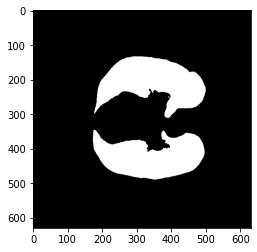

In [9]:
# Exploring the data 
imgPath = os.path.join(imagePathInput, '1.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)


maskPath = os.path.join(maskPathInput, '1.nii.gz')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

# Showing image slice
imgSlice = mask[:,:,20]
plt.imshow(imgSlice, cmap='gray')
plt.show()

## Region based Segmentation

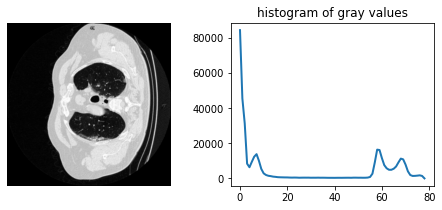

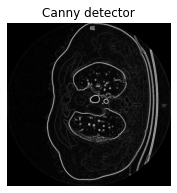

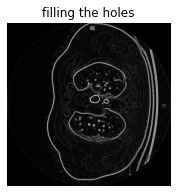

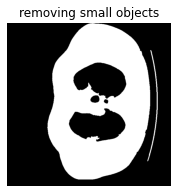

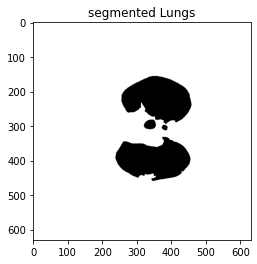

In [85]:
## Reading the image in gray scale and gussian blurring
n= cv2.imread("/content/gdrive/MyDrive/Segmentation/slices/img/t0-slice008_z.png")
n= cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
n = cv2.GaussianBlur(n, (5, 5), 0)

# Checking image histogram for extreme values to be used as markers later 5&70
hist, hist_centers = histogram(n)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(n, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

# The sobel edge detector
#img = canny(n) 
img = sobel(n)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(img, cmap=plt.cm.gray)
ax.set_title('Canny detector')
ax.axis('off')

# The markers chosen from the histogram of the image
markers = np.zeros_like(n)
markers[n < 5] = 1  # Chosen extreme from histogram
markers[n > 70] = 2  # Chosen extreme from histogram

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(img, cmap=plt.cm.gray)
ax.set_title('filling the holes')
ax.axis('off')

#img = cv2.erode(img, None, iterations=2)
#img = cv2.dilate(img, None, iterations=2)

# water shed segmentaiton
segmentation_coins = segmentation.watershed(img, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation_coins, cmap=plt.cm.gray)
ax.set_title('removing small objects')
ax.axis('off')

# Modifying the background to exctract the segmetned lungs
ret, gray = ret, gray = cv2.threshold(segmentation_coins.astype(np.uint8), 1, 255, cv2.THRESH_BINARY)
for x in range(gray.shape[1]):
    # Fill dark top pixels:
 if gray[0, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, 0), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark bottom pixels:
 if gray[-1, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, gray.shape[0]-1), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color

for y in range(gray.shape[0]):
    # Fill dark left side pixels:
 if gray[y, 0] == 0:
      cv2.floodFill(gray, None, seedPoint=(0, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark right side pixels:
 if gray[y, -1] == 0:
      cv2.floodFill(gray, None, seedPoint=(gray.shape[1]-1, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color

fig, ax = plt.subplots()
plt.imshow(gray, cmap='gray')
ax.set_title('segmented Lungs')
plt.show()


## Replacing images with their segmented slices in the directory

In [102]:
## The images in the "/content/gdrive/MyDrive/Segmentation/slices/img/*.png" will be replaced by their masks via region based segmetnation

for m in glob.glob("/content/gdrive/MyDrive/Segmentation/slices/img/*.png"):
    n=cv2.imread(m)
    n= cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    n = cv2.GaussianBlur(n, (5, 5), 0)

    img = sobel(n)

    markers = np.zeros_like(n)
    markers[n < 5] = 1  # Chosen extreme from histogram
    markers[n > 70] = 2  # Chosen extreme from histogram

    segmentation_coins = segmentation.watershed(img, markers)
 
    # Modifying the background to exctract the segmetned lungs
    ret, gray = ret, gray = cv2.threshold(segmentation_coins.astype(np.uint8), 1, 255, cv2.THRESH_BINARY)
    for x in range(gray.shape[1]):
    # Fill dark top pixels:
     if gray[0, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, 0), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark bottom pixels:
     if gray[-1, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, gray.shape[0]-1), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color

    for y in range(gray.shape[0]):
    # Fill dark left side pixels:
     if gray[y, 0] == 0:
      cv2.floodFill(gray, None, seedPoint=(0, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark right side pixels:
     if gray[y, -1] == 0:
      cv2.floodFill(gray, None, seedPoint=(gray.shape[1]-1, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    
    file_name, file_ext = os.path.splitext(m)
    gray = im.fromarray(gray)
    #img = im.fromarray(img)
    gray.save('{}.png'.format(file_name))

## Using Dice Coeffecient for measuring the perforrmamce of the segmetnaton 

In [100]:
## Segmetnation Quantifying Measure (Dice coeffecient)

def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            
            lenIntersection=0
            
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: De

(630, 630, 3)
(630, 630, 3)
Dice coeffecient value is 0.8577651801461326


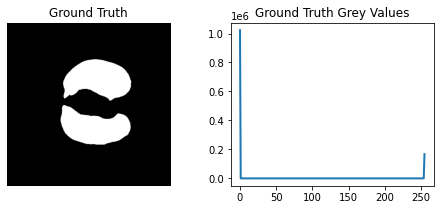

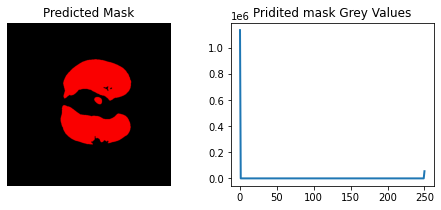

In [125]:
## Ground Truth Mask
img = cv2.imread('/content/gdrive/MyDrive/Segmentation/slices/mask/t0-slice012_z.png')

hist, hist_centers = histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Ground Truth Grey Values')

#print(img)
img = np.asarray(img).astype(np.bool)
#print(img)
print(img.shape)
#print('_'*40)

## Predicted mask
img2 = cv2.imread('/content/gdrive/MyDrive/Segmentation/slices/img/t0-slice012_z.png')
img2 = cv2.subtract(250, img2)

hist, hist_centers = histogram(img2)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img2, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('Predicted Mask')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Pridited mask Grey Values')

#print(img2)
img2 = np.asarray(img2).astype(np.bool)

#print(img2)
print(img2.shape)
#print('%'*40)

value = dice_coef(img, img2)
print("Dice coeffecient value is", value) 

In [132]:
## Checking Dice values for all slices in the dataset (image volumes and lung musks)
GT_path = '/content/gdrive/MyDrive/Segmentation/slices/mask/'
pred_path = '/content/gdrive/MyDrive/Segmentation/slices/img/'

import os

# specify the img directory path
path = "path/to/img/folder/"

# list files in img directory
files = os.listdir(GT_path)
files2 = os.listdir(pred_path)

dicee = []
for file in files:
    # make sure file is an image
    if file.endswith('.png'):
      for filee in files2:
        if filee == file:
          ## Ground Truth Mask
          img = cv2.imread(GT_path + file)
          img = np.asarray(img).astype(np.bool)

          ## Predicted mask
          img2 = cv2.imread(pred_path + filee)
          img2 = cv2.subtract(250, img2)
          img2 = np.asarray(img2).astype(np.bool)

          value = dice_coef(img, img2)
          print("Dice coeffecient value is", value, "\n") 
          dicee.append(value)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Dice coeffecient value is 0.9783371126228269 

Dice coeffecient value is 0.9926732174351222 

Dice coeffecient value is 0.9631242126480222 

Dice coeffecient value is 0.9503955656336609 

Dice coeffecient value is 0.8429931972789115 

Dice coeffecient value is 0.93623330813807 

Dice coeffecient value is 0.8400050390526581 

Dice coeffecient value is 0.8439027462836987 

Dice coeffecient value is 0.8400730662635425 

Dice coeffecient value is 0.8397178130511463 

Dice coeffecient value is 0.8411438649533888 

Dice coeffecient value is 0.8429528848576467 

Dice coeffecient value is 0.8419727891156462 

Dice coeffecient value is 0.8412018140589569 

Dice coeffecient value is 0.8410330057949106 

Dice coeffecient value is 0.8394280675233056 

Dice coeffecient value is 0.843466868228773 

Dice coeffecient value is 0.8317031997984379 

Dice coeffecient value is 0.8338070042831948 

Dice coeffecient value is 0.8313932980599648 

Dice coeffecient value is 0.8291710758377425 

Dice coeffecient

In [139]:
dicee = np.array(dicee)

In [144]:
#len = len(dicee)
print("Number of Values is", len)

# Taking average of dice values
av=np.mean(dicee)
print ("average dice values is", av)

# Taking maximuim and minimuim of dice values
mx=np.max(dicee)
print ("maximuim dice values is", mx)

mn=np.min(dicee)
print ("minimuim dice values is", mn)

Number of Values is 829
average dice values is 0.8931156085719818
maximuim dice values is 1.0
minimuim dice values is 0.7450415721844293
